# Package Imports / Set Random State

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# help balance skewed data
from imblearn.over_sampling import SMOTE

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from xgboost import XGBClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics import confusion_matrix, roc_auc_score

# visualization
from sklearn import tree

random_state = 0

# Load Dataset

In [2]:
transactions_df = pd.read_csv('data/clean_engineered_with_outliers.csv')
transactions_df.head(2)

,accountNumber,creditLimit,availableMoney,transactionAmount,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,pairedWithReversal,...,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL
0,100088067,50000,50000.00,205.13,4615,0.00,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,100088067,50000,49794.87,46.43,4615,205.13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Data Visualization to help with Feature Selection
- to help see feature correlations
- to reduce feature data dimensionality
- to reduce noise in the data and prevent overfitting

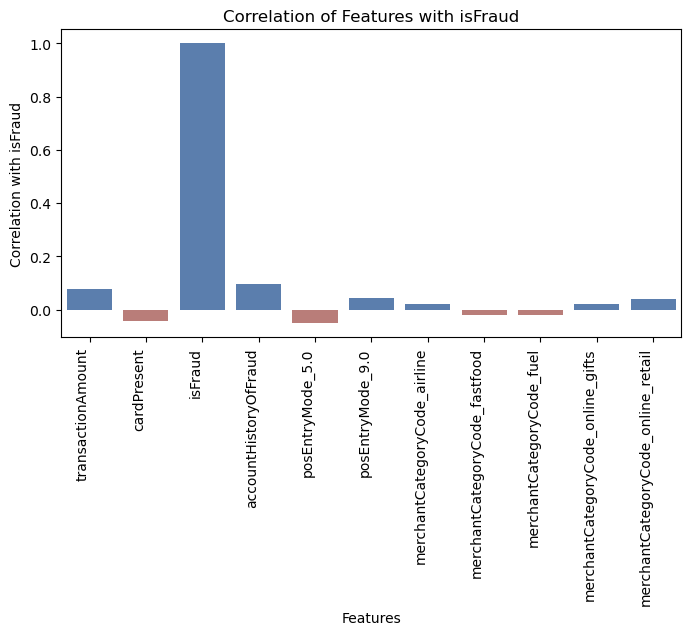

In [3]:
# create correlation heatmap for all features against all features
corr = transactions_df.corr()

# get correlation of features with isFraud (using a threshold to avoid showing large number of features)
threshold = 0.02
corr_with_fraud = corr['isFraud']
corr_with_fraud = corr_with_fraud[abs(corr_with_fraud) > threshold]

# set blue -> positive correlation, red -> negative correlation to help with visualization
colors = ['#4E7CBA' if corr >= 0 else '#C4736E' for corr in corr_with_fraud]

# plot correlations in bar chart
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=corr_with_fraud.index, y=corr_with_fraud.values, palette=colors)

plt.xlabel('Features')
plt.ylabel('Correlation with isFraud')
plt.title('Correlation of Features with isFraud')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right') # rotate x-axis labels to avoid overlap
plt.show()

# drop columns that are not within the threshold for correlation with isFraud
cols_to_drop = [col for col in transactions_df.columns if col not in corr_with_fraud.index]
transactions_df.drop(columns=cols_to_drop, inplace=True)

In [4]:
transactions_df.head(2)

,transactionAmount,cardPresent,isFraud,accountHistoryOfFraud,posEntryMode_5.0,posEntryMode_9.0,merchantCategoryCode_airline,merchantCategoryCode_fastfood,merchantCategoryCode_fuel,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail
0,205.13,1,0,0,0,0,0,0,0,0,0
1,46.43,1,0,0,1,0,0,0,0,0,0


# Create Hold Out Set For Evaluation

In [5]:
# drop the target variable from features and store features separately
X = transactions_df.drop(columns=['isFraud'])
y = transactions_df['isFraud']

# create a hold out set to test the final model while retaining fraud/no fraud class distribution
# stratify by isFraud to retain class distribution
X, X_holdout, y, y_holdout = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True, stratify=y)

# calculate percentage of fraud in train and hold out set
print('Percentage of fraud label in train set: ', round(y.sum() / len(y) * 100, 2))
print('Percentage of fraud label in hold out set: ', round(y_holdout.sum() / len(y_holdout) * 100, 2))

Percentage of fraud label in train set:  1.58
Percentage of fraud label in hold out set:  1.58


# Dataset Balancing + Stratified K-Fold Cross Validation
- this dataset is extremely imbalanced, I will use the SMOTE technique to create a balanced dataset and then use both datasets to train my models and perform a comparison
- in addition, I will use stratified k-fold cross validation to retain the balanced percentages of samples per class in each fold
- k fold cross validation helps detect overfitting!

In [6]:
# balance the dataset using SMOTE - upsample minority class to 50% of majority class
# Note: I played with sampling_strategy = [0.1, 0.2, 0.3, 0.4, 0.5]
smote = SMOTE(random_state=random_state, sampling_strategy=0.5, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [7]:
# wrapper method for training and evaluating a model on both the BALANCED and IMBALANCED datasets
def train_evaluate_model(model, mode='train'):
    '''
    Trains and evaluates a model on both the balanced and imbalanced datasets.
    Prints out evaluation metrics and plots confusion matrix.

    Parameters:
        model (sklearn model): model to train and evaluate
        mode (str): 'train' or 'validation' to indicate whether to train on train set or validation/holdout set

    Returns:
        None
    '''
    modelcopy = deepcopy(model)

    if mode == 'validation':
        # fit on the entire dataset
        model.fit(X, y)

        # fit on SMOTE balanced dataset
        modelcopy.fit(X_balanced, y_balanced)

        try:
            y_pred = model.predict(X_holdout)
            y_pred_balanced = modelcopy.predict(X_holdout)
        except AttributeError:
            y_pred = model.fit_predict(X_holdout)
            y_pred_balanced = modelcopy.fit_predict(X_holdout)

        print("HOLDOUT RESULTS - ROC AUC SCORE")
        print("------------------------------------------------------------")
        print("{:<30} | {:<30}".format("TRAINED ON UNBALANCED DATASET", "TRAINED ON BALANCED DATASET"))
        print("{:<30} | {:<30}".format(roc_auc_score(y_holdout, y_pred), roc_auc_score(y_holdout, y_pred_balanced)))

        unbalanced_confusion_matrix = confusion_matrix(y_holdout, y_pred)
        balanced_confusion_matrix = confusion_matrix(y_holdout, y_pred_balanced)
    elif mode == 'train':
        n_splits = 5

        # train on unbalanced dataset
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        unbalanced_roc_auc = []
        unbalanced_confusion_matrix = np.zeros((2, 2)) # since this is binary classification
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # features
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # target

            model.fit(X_train, y_train)
            try:
                y_pred = model.predict(X_test)
            except AttributeError: # if model doesn't have fit(), use fit_predict()
                y_pred = model.fit_predict(X_test)

            unbalanced_roc_auc.append(roc_auc_score(y_test, y_pred))
            unbalanced_confusion_matrix += confusion_matrix(y_test, y_pred)

        # train on balanced dataset
        skf_balanced = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        balanced_roc_auc = []
        balanced_confusion_matrix = np.zeros((2, 2))
        for train_index, test_index in skf_balanced.split(X_balanced, y_balanced):
            X_train_balanced, X_test_balanced = X_balanced.iloc[train_index], X_balanced.iloc[test_index]  # features
            y_train_balanced, y_test_balanced = y_balanced.iloc[train_index], y_balanced.iloc[test_index]  # target

            modelcopy.fit(X_train_balanced, y_train_balanced)
            try:
                y_pred_balanced = modelcopy.predict(X_test_balanced)
            except AttributeError:
                y_pred_balanced = modelcopy.fit_predict(X_test_balanced)

            balanced_roc_auc.append(roc_auc_score(y_test_balanced, y_pred_balanced))
            balanced_confusion_matrix += confusion_matrix(y_test_balanced, y_pred_balanced)

        # print out evaluation metrics
        print("UNBALANCED DATASET - ROC AUC SCORES")
        print("----------------------------------------------------------------")
        print("{:<20} | {:<20} | {:<20}".format("avg", "min", "max"))
        print("{:<20} | {:<20} | {:<20}".format(sum(unbalanced_roc_auc) / len(unbalanced_roc_auc), min(unbalanced_roc_auc), max(unbalanced_roc_auc)))
        print("################################################################")
        print("BALANCED DATASET - ROC AUC SCORES")
        print("----------------------------------------------------------------")
        print("{:<20} | {:<20} | {:<20}".format("avg", "min", "max"))
        print("{:<20} | {:<20} | {:<20}".format(sum(balanced_roc_auc) / len(balanced_roc_auc), min(balanced_roc_auc), max(balanced_roc_auc)))

    # plot confusion matrix
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.subplots_adjust(wspace=0.5)
    ax1, ax2 = axs

    visualize_confusion_matrix(unbalanced_confusion_matrix.astype(int), label='UNBALANCED DATASET', ax=ax1)
    visualize_confusion_matrix(balanced_confusion_matrix.astype(int), label='BALANCED DATASET', ax=ax2)

In [8]:
def visualize_confusion_matrix(cm, label, ax):
    '''
    Plots a confusion matrix with specialized annotations.
    NOTE: confusion_matrix[i, j] represents # number of samples with true label being i-th class and predicted label being j-th class.

    [[TN, FP],
     [FN, TP]]

    Parameters:
        cm (np.array): confusion matrix

    Returns:
        ax (matplotlib.axes.Axes): axes object with confusion matrix plotted
    '''
    # class labels
    class_labels = ['not fraud', 'fraud']

    # sum across TRUE labels to get percentage of each class
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_percentage = cm / cm_sum.astype(float) * 100

    annot = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = cm_percentage[i, j]
            count = cm[i, j]

            annot[i, j] = '%.4f%%\n%d' % (percentage, count)

    sns_cm = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    sns_cm.set_xlabel("Predicted Labels")
    sns_cm.set_ylabel("True Labels")
    sns_cm.set_title(f"Confusion Matrix ({label})")
    
    return sns_cm

# Supervised Techniques
The first supervised learning technique that came to mind was logistic regression. It is often used in binary classification problems but runs the risk of overfitting on high dimensional data. However, this can be combatted with regularization techniques.

Then, thought of decision trees/random forests/gradient boosting came to mind as they are also commonly used in classification problems. Once again, there is the risk of overfitting due to the high dimensional feature data I provide, but this can be combatted with pruning.

## Logistic Regression

UNBALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.5000422769580292   | 0.49997981119428897  | 0.5002436868792836  
################################################################
BALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.7226442111749941   | 0.7209397964549662   | 0.7239115662221711  


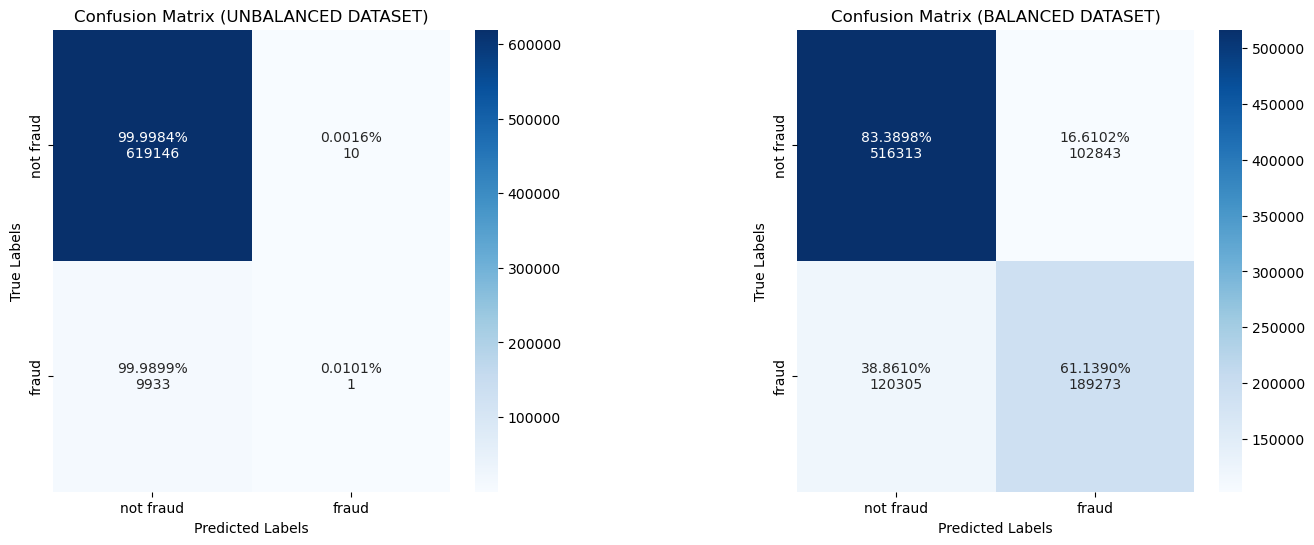

In [44]:
# ran into an error with the default lbfgs solver so I experimented with others like 'newton-cholesky', 'liblinear', 'newton-cg', 'sag', 'saga'
# newton-cholesky is said to be quite fast on large datasets (with the tradeoff of possibly not converging in some cases)
'''
/Users/austinpeng/opt/anaconda3/envs/c1-ds-challenge/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
'''
logreg = LogisticRegression(solver='newton-cholesky', random_state=random_state)
train_evaluate_model(logreg)

HOLDOUT RESULTS - ROC AUC SCORE
------------------------------------------------------------
TRAINED ON UNBALANCED DATASET  | TRAINED ON BALANCED DATASET   
0.500402738622634              | 0.6787138210742019            


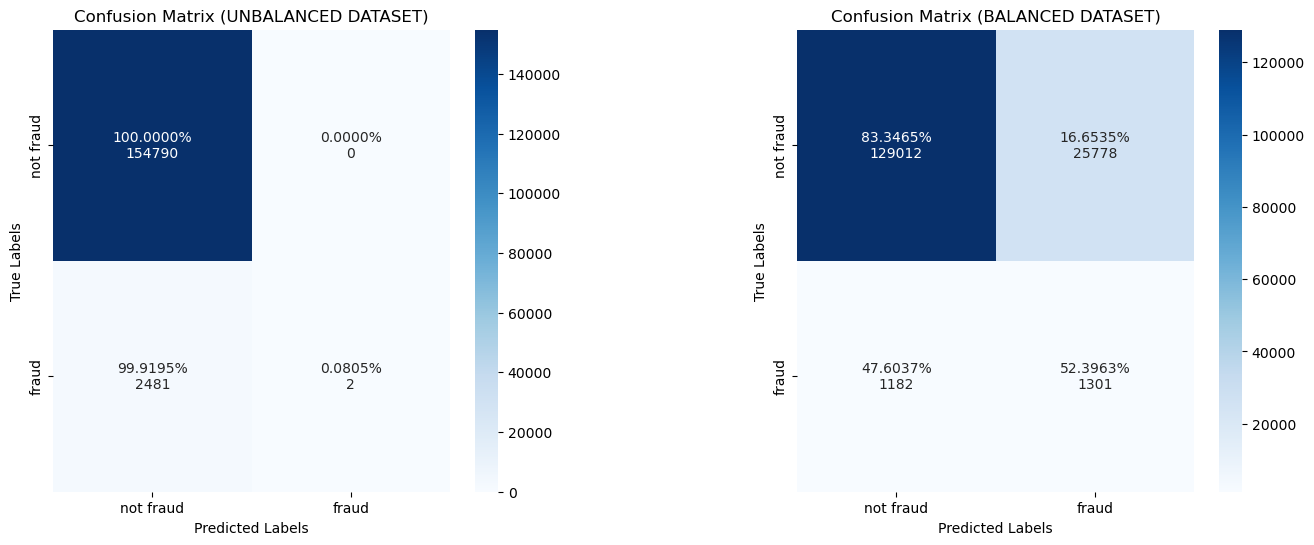

In [45]:
train_evaluate_model(logreg, mode='validation')

## Logistic Regression + Hyperparameter Tuning

In [59]:
logreg_gs = GridSearchCV(logreg, param_grid={
    'solver': ['newton-cholesky'],
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1],
    'class_weight': [None, 'balanced']
}, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

logreg_fit_unbalanced = logreg_gs.fit(X, y)

# get best parameters for unbalanced dataset
print(f"Unbalanced dataset best params: {logreg_fit_unbalanced.best_params_}")
print(f"Unbalanced dataset best roc auc score: {logreg_fit_unbalanced.best_score_}")


logreg_fit_balanced = logreg_gs.fit(X_balanced, y_balanced)

# get best parameters for balanced dataset
print(f"Balanced dataset best params: {logreg_fit_balanced.best_params_}")
print(f"Balanced dataset best roc auc score: {logreg_fit_balanced.best_score_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Unbalanced dataset best params: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cholesky'}
Unbalanced dataset best roc auc score: 0.813294348682688
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Balanced dataset best params: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cholesky'}
Balanced dataset best roc auc score: 0.8351401618659994


HOLDOUT RESULTS - ROC AUC SCORE
------------------------------------------------------------
TRAINED ON UNBALANCED DATASET  | TRAINED ON BALANCED DATASET   
0.7237741963524978             | 0.7205839023142757            


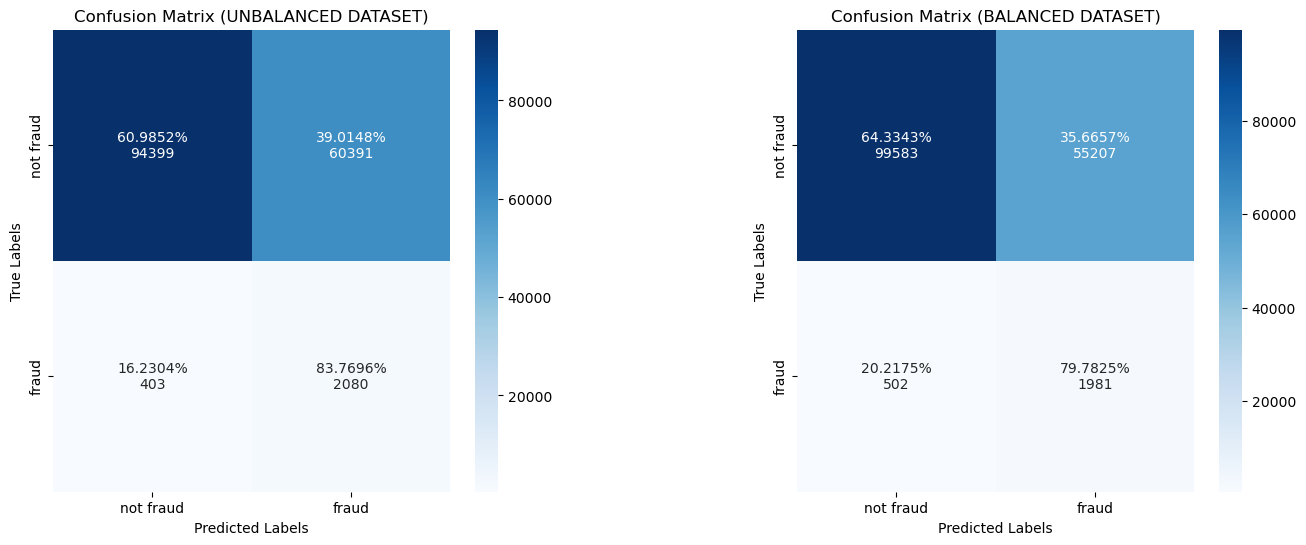

In [77]:
# the logistic regression model tuned on the balanced dataset performs better overall on the holdout set
logreg_tuned_unbalanced = LogisticRegression(
    solver='newton-cholesky',
    penalty='l2',
    C=1,
    class_weight='balanced',
    random_state=random_state
)

logreg_tuned_balanced = LogisticRegression(
    solver='newton-cholesky',
    penalty='l2',
    C=0.001,
    class_weight='balanced',
    random_state=random_state
)

train_evaluate_model(logreg_tuned_balanced, mode='validation')

## Decision Tree Classifier

UNBALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.5255641710162481   | 0.5230066265167306   | 0.5272763567317386  
################################################################
BALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.8104863668808454   | 0.8097924802131542   | 0.8112640382558574  


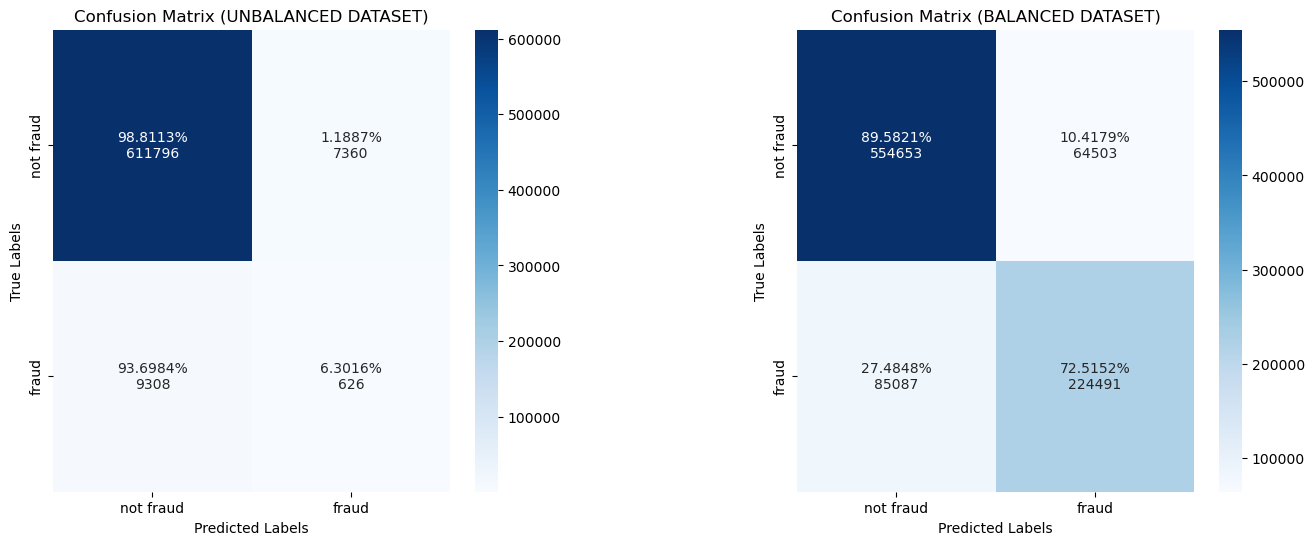

In [13]:
dt = DecisionTreeClassifier(random_state=random_state)

train_evaluate_model(dt)

HOLDOUT RESULTS - ROC AUC SCORE
------------------------------------------------------------
TRAINED ON UNBALANCED DATASET  | TRAINED ON BALANCED DATASET   
0.5300799932726857             | 0.5828872758297998            


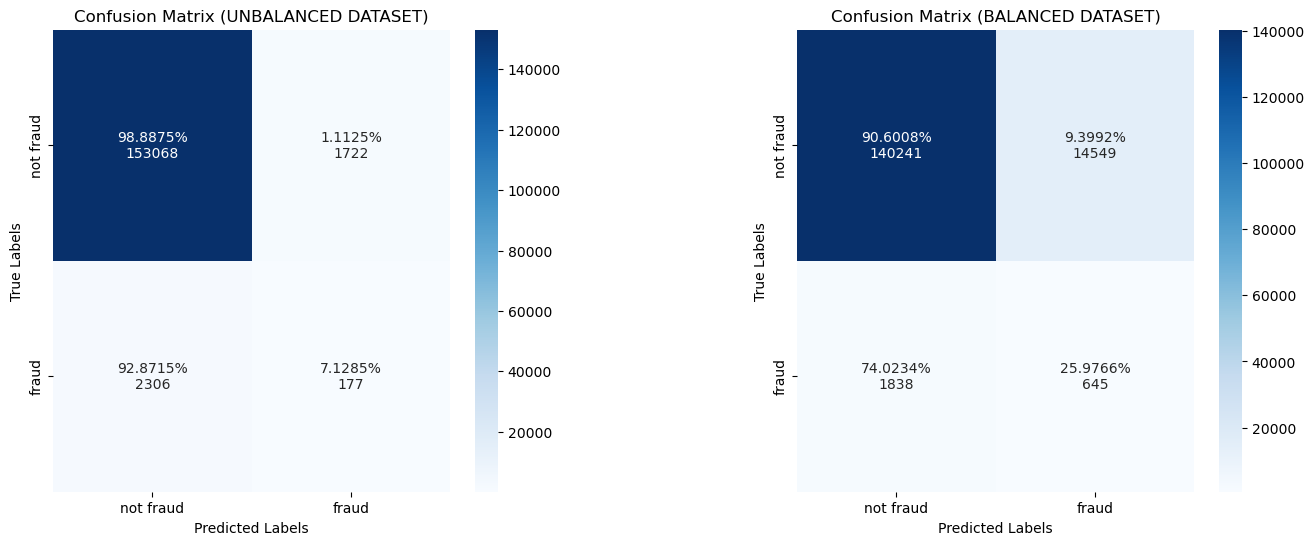

In [14]:
train_evaluate_model(dt, mode='validation')

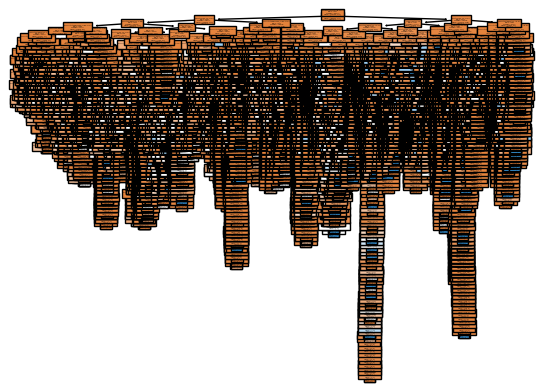

In [15]:
# visualize decision tree
_ = tree.plot_tree(dt, feature_names=X.columns, class_names=['0', '1'], filled=True)

## Decision Tree Classifier + Hyperparameter Tuning

In [64]:
dt_gs = GridSearchCV(dt, param_grid={
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [i for i in range(10, 100, 10)],
    # 'min_samples_split': [i for i in range(2, 10, 2)],
    # 'min_samples_leaf': [i for i in range(1, 10, 2)],
}, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

dt_fit_unbalanced = dt_gs.fit(X, y)

# get best parameters for unbalanced dataset
print(f"Unbalanced dataset best params: {dt_fit_unbalanced.best_params_}")
print(f"Unbalanced dataset best roc auc score: {dt_fit_unbalanced.best_score_}")


dt_fit_balanced = dt_gs.fit(X_balanced, y_balanced)

# get best parameters for balanced dataset
print(f"Balanced dataset best params: {dt_fit_balanced.best_params_}")
print(f"Balanced dataset best roc auc score: {dt_fit_balanced.best_score_}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Unbalanced dataset best params: {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
Unbalanced dataset best roc auc score: 0.817400178296468
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Balanced dataset best params: {'criterion': 'entropy', 'max_depth': 20, 'splitter': 'best'}
Balanced dataset best roc auc score: 0.8898557785286677


HOLDOUT RESULTS - ROC AUC SCORE
------------------------------------------------------------
TRAINED ON UNBALANCED DATASET  | TRAINED ON BALANCED DATASET   
0.5003962782569772             | 0.6810525514970889            


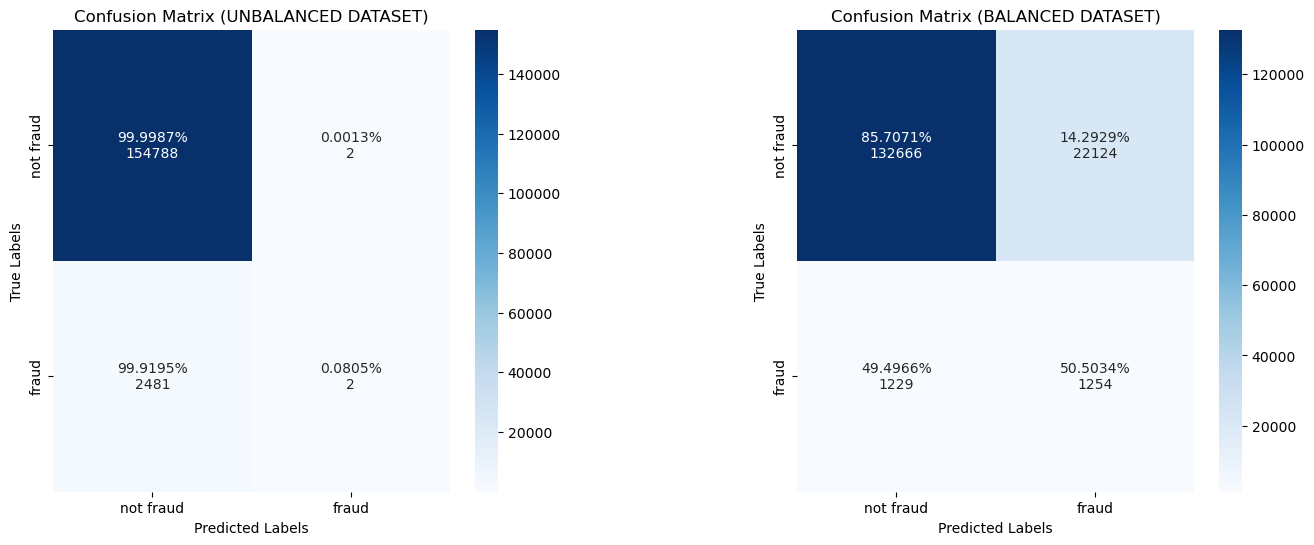

In [73]:
# the decision tree model tuned on the unbalanced dataset performs better overall on the holdout set
dt_tuned_unbalanced = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    splitter='random',
    random_state=random_state
)

dt_tuned_balanced = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=20,
    splitter='best',
    random_state=random_state
)
train_evaluate_model(dt_tuned_unbalanced, mode='validation')

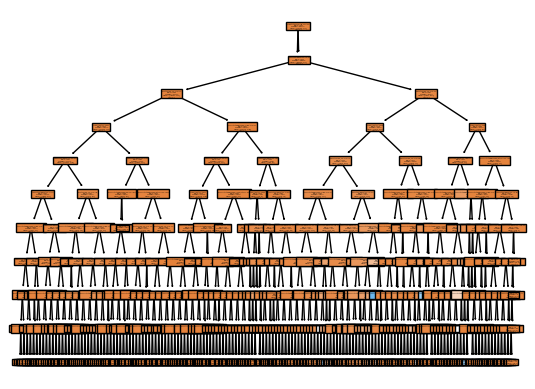

In [74]:
# visualize tuned decision tree
_ = tree.plot_tree(dt_tuned_unbalanced, feature_names=X.columns, class_names=['0', '1'], filled=True)

## Random Forest Classifier

UNBALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.526570972678639    | 0.5234520910212822   | 0.5286839320520271  
################################################################
BALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.8098540535577661   | 0.8089970624300511   | 0.8106139488647192  


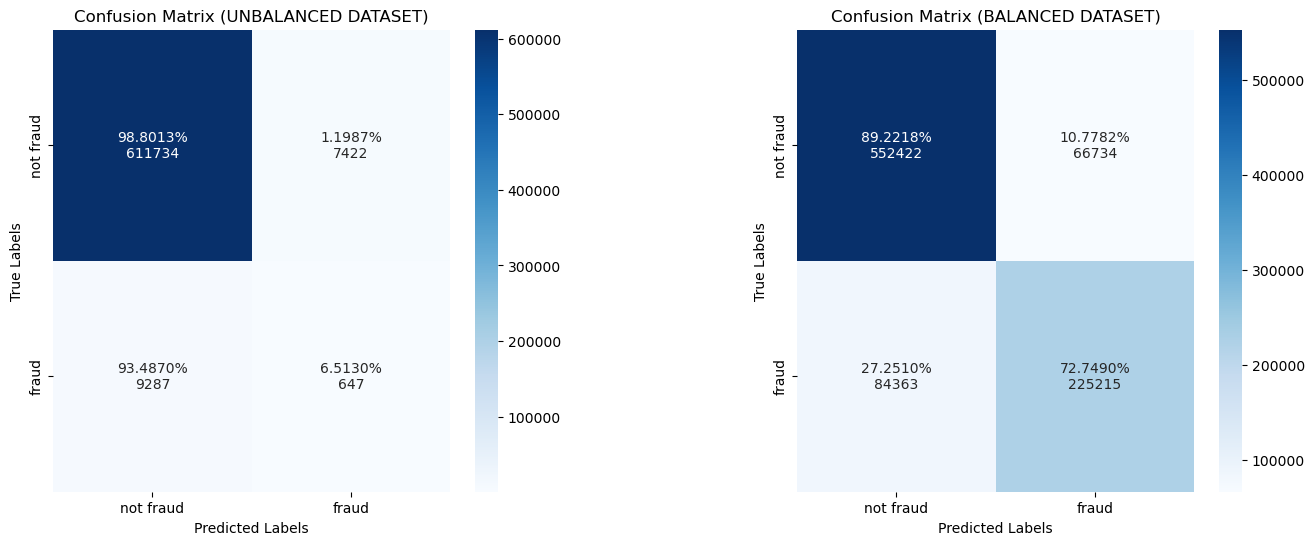

In [16]:
rf = RandomForestClassifier(random_state=random_state)
train_evaluate_model(rf)

HOLDOUT RESULTS - ROC AUC SCORE
------------------------------------------------------------
TRAINED ON UNBALANCED DATASET  | TRAINED ON BALANCED DATASET   
0.5295965000793431             | 0.5889684065743575            


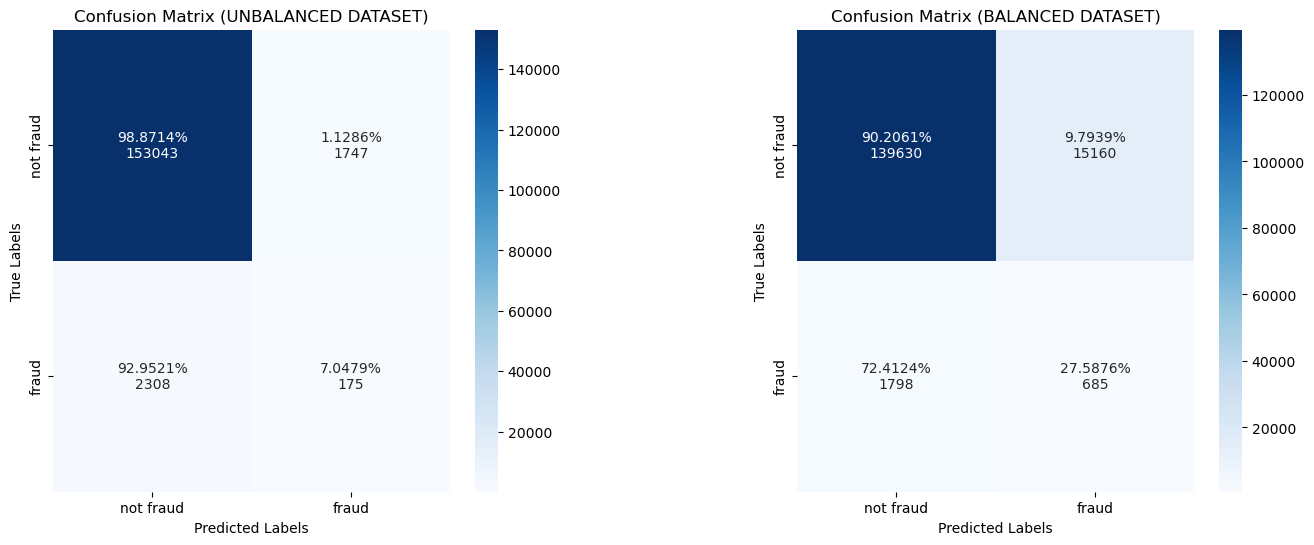

In [17]:
train_evaluate_model(rf, mode='validation')

## Extreme Gradient Boosting (XGBoost)

UNBALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.5000414440583296   | 0.4999838489554312   | 0.5002516356316055  
################################################################
BALANCED DATASET - ROC AUC SCORES
----------------------------------------------------------------
avg                  | min                  | max                 
0.7676013820297902   | 0.7656778717337327   | 0.7695885565904423  


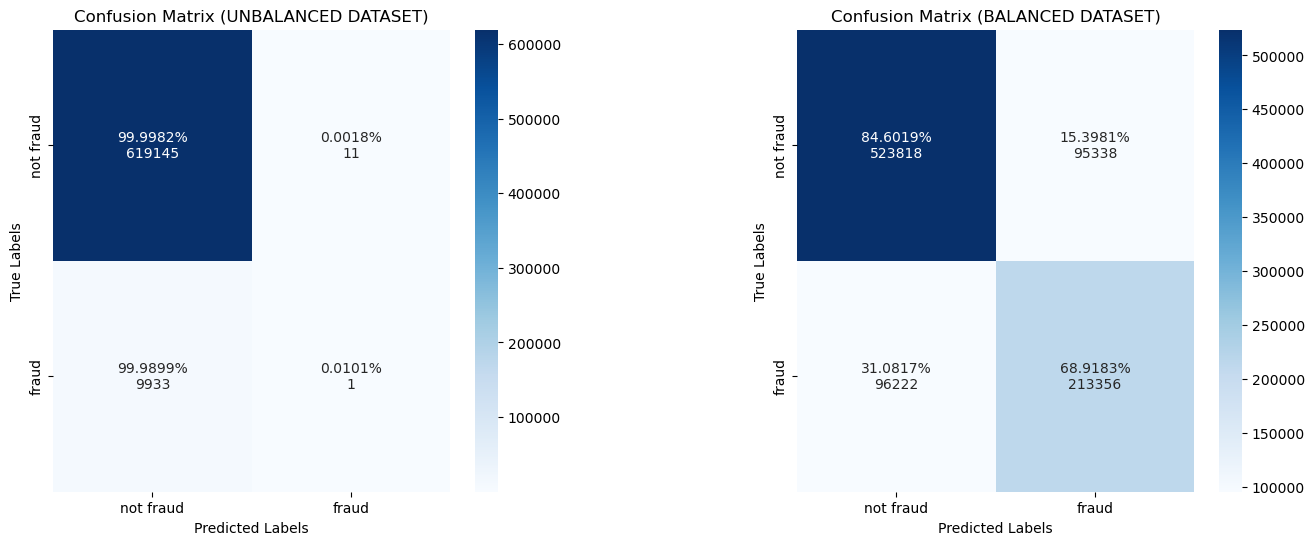

In [42]:
xgb = XGBClassifier(random_state=random_state)
train_evaluate_model(xgb)

HOLDOUT RESULTS - ROC AUC SCORE
------------------------------------------------------------
TRAINED ON UNBALANCED DATASET  | TRAINED ON BALANCED DATASET   
0.49999676981717167            | 0.6699165033514156            


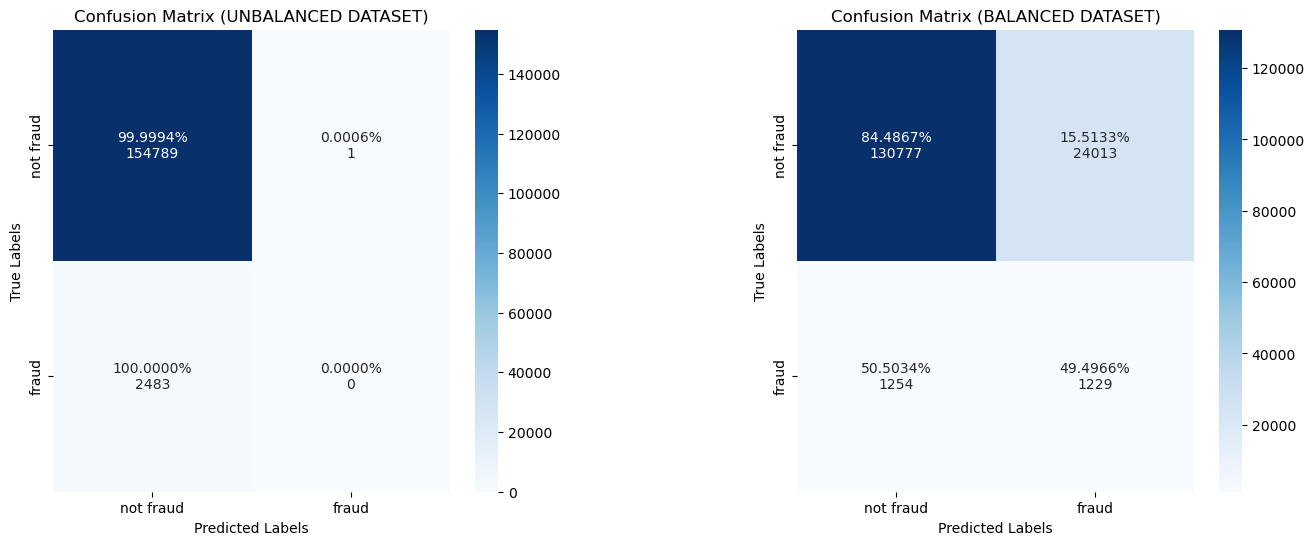

In [43]:
train_evaluate_model(xgb, mode='validation')

# Unsupervised Techniques
- Need more time for this... support vector machines take an extremely long time to train.
- Considering that my data is high dimensional and SVMs have quadratic complexity, training time skyrockets with the number of data points (which we have a lot of).

In [20]:
# ocsvm = OneClassSVM()
# train_evaluate_model(ocsvm)

In [21]:
# train_evaluate_model(ocsvm, mode='validation')

# Question 4 - Model
Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

**Useful Features**

- Through my data visualization to see the correlation of the original features and the features I engineered, I found that 'accountHistoryOfFraud' (aka whether an account has had an account marked as fraud) was a very useful feature. However, after some thought, there are some major issues with this feature depending on the use case of this model.
    - If the purpose of this fraud detection model is to be used in a context where a credit card transaction dataset doesn't contain the 'isFraud' label, then this feature could not be generated. For example, the fraud detection model was trained on the dataset I was given (containing 'isFraud' labels) and applied to a different dataset without 'isFraud' labels. Then it is possible that the models I trained to perform poorly on the new data.
    - However, considering Capital One as a company and their use case, I would assume that they would have access to some extent of historical account data. In this case, the models I generate would be able to be trained with data containing the 'isFraud' label. The 'accountHistoryOfFraud' would be an available feature.

- One final point to note is that relying on historical data comes with the weakness of having little to no information on new accounts (where fraud can often occur in).

**Quick Run Down Of Train/Test/Validation**

- I split the dataset into a train and holdout set (80/20 split) to train and evaluate my models.
- I perform k-fold cross validation on the train set to train and check for overfitting.
- I train the model on the entire train set and evaluate on the holdout set.

**Dataset Imbalance**

- Because of the dataset imbalance (only ~1.58% of the records are of 'fraud' class) I decided to use synthetic minority oversampling technique (SMOTE) to adjust the class imbalance.
- For all models when trained on the unbalanced dataset, it almost seemed like they followed the rule of "predict not fraud" due to the extremely low counts of false positives and true positives. It seems the balanced dataset yields a more reasonable distribution of false positives and true negatives.
- This shows that these techniques are actually effective when it comes to handling class imbalances for an anomaly detection problem like fraud.
- I played around with SMOTE's sampling strategy using different for ratios for samples_in_minority_class over sample_of_majority_class. I found that increasing this ratio yielded better and better performance for all models on the ROC AUC scoring metric.

**Noticed High False Negative Rate**

- I see the high false negative rate as a major issue because from the company standpoint, it would cause them to lose money (due to undetected fraud cases). I believe it is more useful to have a higher false positive rate because these predictions can be used to "check-in" with customers and see if that actually made the transaction. If the customer did not make the transaction, then the company can take the appropriate actions to prevent the transaction from going through and mark it as fraud! In the scenario where the customer actually did make the transaction, we can use this data to improve our model and reduce the false positive rate over time.

**Models Utilized**

- While choosing models to use for this challenge, I focused mainly on supervised techniques because I believe in the practical use cases of this fraud detection model, the company would already have existing data on their customer's transactions (ex. prior transactions marked as fraud and not fraud). Although the data may not be perfectly labeled (as not all fraudulent transactions are detected), it is a good starting point for supervised learning techniques.

**Model Findings**

- The logistic regression model with class weights performed the best overall on the holdout data. This model yields significantly lower false negatives with a slight increase of false positives when compare to the other models. This is a trade-off I am willing to make as I believe it is more important to overshoot than underestimate for a model designed to detect fraudulent transactions (see "Noticed High False Negative Rate" for my argument). However, class weights seem to be more effective at trading off false negatives for false positives than balancing the dataset.

- The decision tree and random forest models performed similarly and as expected, overfit on the training data (performance in training greatly exceeded performance on holdout data). To confirm, I visualized the final decision tree and found its max tree depth was 101 nodes. To combat this, I attempted to limit the depth of the decision tree. Other methods include pre- and post-pruning of the tree. After hyperparameter tuning, I found a max depth of 10 actually yielded the best results on the holdout set, improving the model's score from 0.58 -> 0.68. I'm curious if the decision tree model could be improved even further with more research.

- The XGboost model seemed to perform better on the balanced dataset and also overfit on the training data. I did not get the opportunity for hyperparameter tuning with grid search as it took too long to compute.

- With more time, I would attempt to perform deeper hyperparameter tuning with grid search on additional model parameters to further improve the performance of the selected models. I would also like to learn more about the XGBoost model and its hyperparameters as I am least familiar with this topic! With more time, I would also like to use SVMs because they are used for anomaly detection problems. However, the model took too long to train and I was unable to get results in a reasonable amount of time. I believe this is due to the high dimensionality of my dataset and the quadratic complexity of SVMs.

**Evaluation Metric**

- I decided to use the receiver operating characteristic (ROC) curve to evaluate my models, specifically, the area under the ROC curve. I decided on this metric over accuracy because it is sensitive to imbalanced datasets by providing a comprehensive view of how well the model can distinguish between positive and negative examples at various trade-off points between true positive rate and false positive rate. In addition, taking the area under the curve allows us to compare different models easy without having to pick a classification threshold (aka the probability at which a result is considered positive or negative class). Essentially, we want to maximize the area under the ROC curve to get the best model!

**Questions/Future Work**

- Note: I've sprinkled in some future work as I talked about the other sections above.

- From a software design standpoint, I would probably modularize each model into its own class and save the final weights of the models to a file. This way, collaborators don't need to sit and watch the python notebook run. In addition, the models can be easily loaded and used with new data or even in a production environment.

- I briefly tested the effect of different sampling ratios with the synthetic minority oversampling technique (SMOTE). My main question is whether SMOTE should be used. Based on my quick tests, it seems like SMOTE has a positive effect and improves the performance of all the models I have selected. I would like to perform definitive tests for SMOTE sampling ratios from 0.1 to 1 to see what value best supports model performance. In addition, I'm curious on why we would want to balance such a dataset. I understand balancing a dataset makes training easier by preventing the model from becoming biased towards one class. However, fraudulent transactions in a transactions dataset will be inherently underrepresented. Is it possible for a model to learn this fact or is dataset balancing a necessary task?

- Another question I have is how I can tune the hyperparameters of the decision tree even further to achieve the high performance I saw on the training data.

- Finally, I would like to perform more feature engineering to generate more historical features about each account (ex. typical transaction time, transaction frequencies, etc.), do more research on anomaly detection models (ex. one class SVM, autoencoders) + neural networks, performing hyperparameter tuning on a wider selection of model parameters, and even the possibility of solving this fraud detection problem with time-series models!